# Automatic Differentiation (AD)

We all know how to take derivatives.
```julia
f(x) = 5*x^2 + 3

df(x) = 10*x

ddf(x) = 10
```

The promise of AD is

```julia
df(x) = derivative(f, x)

ddf(x) = derivative(df, x)
```

### What AD is not

(https://www.jmlr.org/papers/volume18/17-468/17-468.pdf)

**Symbolic differentiation:** (at least not exactly)
$$ \frac{d}{dx}x^n = n x^{n-1}. $$

**Numerical differentiation:**
$$ \frac{df}{dx} \approx \frac{f(x+h) - f(x)}{\Delta h} $$

## Forward mode AD

Key to AD is the application of the chain rule
$$\dfrac{d}{dx} f(g(x)) = \dfrac{df}{dg} \dfrac{dg}{dx}$$

Consider the function $f(a,b) = \ln(ab + \sin(a))$.

In [1]:
f(a,b) = log(a*b + sin(a))

f (generic function with 1 method)

In [2]:
f_derivative(a,b) = 1/(a*b + sin(a)) * (b + cos(a))

f_derivative (generic function with 1 method)

In [3]:
a = 3.1
b = 2.4
f_derivative(a,b)

0.18724182935843758

Dividing the function into the elementary steps, it corresponds to the following "*computational graph*":

<img src="imgs/comp_graph.svg" width=300px>

In [4]:
function f_graph(a,b)
    c1 = a*b
    c2 = sin(a)
    c3 = c1 + c2
    c4 = log(c3)
end

f_graph (generic function with 1 method)

In [5]:
f(a,b) == f_graph(a,b)

true

To calculate $\frac{\partial f}{\partial a}$ we have to apply the chain rule multiple times.

$\dfrac{\partial f}{\partial a} = \dfrac{\partial f}{\partial c_4} \dfrac{\partial c_4}{\partial a} = \dfrac{\partial f}{\partial c_4} \left( \dfrac{\partial c_4}{\partial c_3} \dfrac{\partial c_3}{\partial a}  \right) = \dfrac{\partial f}{\partial c_4} \left( \dfrac{\partial c_4}{\partial c_3} \left( \dfrac{\partial c_3}{\partial c_2} \dfrac{\partial c_2}{\partial a} + \dfrac{\partial c_3}{\partial c_1} \dfrac{\partial c_1}{\partial a}\right)  \right)$

In [6]:
function f_graph_derivative(a,b)
    c1 = a*b
    c1_ϵ = b
    
    c2 = sin(a)
    c2_ϵ = cos(a)
    
    c3 = c1 + c2
    c3_ϵ = c1_ϵ + c2_ϵ
    
    c4 = log(c3)
    c4_ϵ = 1/c3 * c3_ϵ
    
    c4, c4_ϵ
end

f_graph_derivative (generic function with 1 method)

In [7]:
f_graph_derivative(a,b)[2] == f_derivative(a,b)

true

**How can we automate this?**

In [8]:
# D for "dual number", invented by Clifford in 1873.
struct D <: Number
    x::Float64 # value
    ϵ::Float64 # derivative
end

In [9]:
import Base: +, *, /, -, sin, log, convert, promote_rule

a::D + b::D = D(a.x + b.x, a.ϵ + b.ϵ) # sum rule
a::D - b::D = D(a.x - b.x, a.ϵ - b.ϵ)
a::D * b::D = D(a.x * b.x, a.x * b.ϵ + a.ϵ * b.x) # product rule
a::D / b::D = D(a.x / b.x, (b.x * a.ϵ - a.x * b.ϵ)/b.x^2) # quotient rule
sin(a::D) = D(sin(a.x), cos(a.x) * a.ϵ)
log(a::D) = D(log(a.x), 1/a.x * a.ϵ)

Base.convert(::Type{D}, x::Real) = D(x, zero(x))
Base.promote_rule(::Type{D}, ::Type{<:Number}) = D

In [10]:
f(D(a,1), b)

D(2.0124440881688996, 0.18724182935843758)

Boom! That was easy!

In [11]:
f(D(a,1), b).ϵ ≈ f_derivative(a,b)

true

**How does this work?!**

The trick of forward mode AD is to make the computer do the rewrite `f -> f_graph_derivative` for you (and then optimize the resulting code structure).

In [12]:
@code_typed f(D(a,1), b)

CodeInfo(
1 ─ %1  = Base.getfield(a, :x)::Float64
│   %2  = Base.mul_float(%1, b)::Float64
│   %3  = Base.getfield(a, :x)::Float64
│   %4  = Base.mul_float(%3, 0.0)::Float64
│   %5  = Base.getfield(a, :ϵ)::Float64
│   %6  = Base.mul_float(%5, b)::Float64
│   %7  = Base.add_float(%4, %6)::Float64
│   %8  = Base.getfield(a, :x)::Float64
│   %9  = invoke Main.sin(%8::Float64)::Float64
│   %10 = Base.getfield(a, :x)::Float64
│   %11 = invoke Main.cos(%10::Float64)::Float64
│   %12 = Base.getfield(a, :ϵ)::Float64
│   %13 = Base.mul_float(%11, %12)::Float64
│   %14 = Base.add_float(%2, %9)::Float64
│   %15 = Base.add_float(%7, %13)::Float64
│   %16 = invoke Main.log(%14::Float64)::Float64
│   %17 = Base.div_float(1.0, %14)::Float64
│   %18 = Base.mul_float(%17, %15)::Float64
│   %19 = %new(Main.D, %16, %18)::D
└──       return %19
) => D

While this is somewhat hard to parse, plugging these operations manually into each other we find that this code equals

```julia
D.x = log(a.x*b + sin(a.x))
D.ϵ = 1/(a.x*b + sin(a.x)) * (a.x*0 + (a.ϵ*b) + cos(a.x)*a.ϵ)
```

which, if we drop `a.x*0`, set `a.ϵ = 1`, and rename `a.x` $\rightarrow$ `a`, reads

```julia
D.x = log(a*b + sin(a))
D.ϵ = 1/(a*b + sin(a)) * (b + cos(a)
```

This precisely matches our definitions from above:

```julia
f(a,b) = log(a*b + sin(a))

f_derivative(a,b) = 1/(a*b + sin(a)) * (b + cos(a))
```

Importantly, the compiler sees the entire "rewritten" code and can therefore apply optimizations. In this simple example, we find that the code produced by our simple Forward mode AD is essentially identical to the explicit implementation.

In [ ]:
@code_llvm debuginfo=:none f_graph_derivative(a,b)

In [ ]:
@code_llvm debuginfo=:none f(D(a,1), b)

It's general:

In [14]:
# utility function for our small forward AD
derivative(f::Function, x::Number) = f(D(x, one(x))).ϵ

derivative (generic function with 1 method)

In [ ]:
x->f(x,b)

In [15]:
derivative(x->f(x,b), a)

0.18724182935843758

In [16]:
derivative(x->3*x^2+4x+5, 2)

16.0

In [17]:
derivative(x->sin(x)*log(x), 3)

-1.0405779197678489

Or as a function:

In [18]:
df(x) = derivative(a->f(a,b),x) # partial derivative wrt a

df (generic function with 1 method)

In [19]:
df(1.23)

0.7020787235973817

## Taking derivatives of code: Babylonian sqrt

> Repeat $t \leftarrow (t + x/2)/2$ until $t$ converges to $\sqrt{x}$.

In [20]:
@inline function Babylonian(x; N = 10)
    t = (1+x)/2
    for i = 2:N
        t = (t + x/t)/2
    end
    t
end

Babylonian (generic function with 1 method)

In [23]:
Babylonian(2), sqrt(2)

(1.414213562373095, 1.4142135623730951)

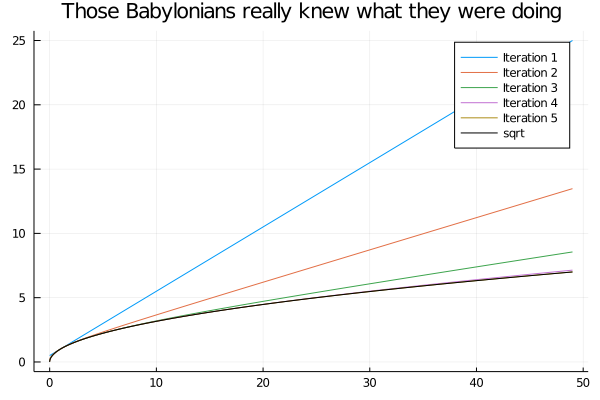

In [22]:
using Plots

xs = 0:0.01:49

p = plot(title = "Those Babylonians really knew what they were doing")
for i in 1:5
    plot!(p, xs, [Babylonian(x; N=i) for x in xs], label="Iteration $i")
end

plot!(p, xs, sqrt.(xs), label="sqrt", color=:black)

## ... and now the derivative, automagically

The same babylonian algorithm with no rewrite at all computes properly the derivative as the check shows.

In [24]:
Babylonian(D(5, 1))

D(2.23606797749979, 0.22360679774997896)

In [25]:
√5, 0.5 / √5

(2.23606797749979, 0.22360679774997896)

It just works and is efficient.

In [ ]:
@code_native debuginfo=:none Babylonian(D(5, 1))

Recursion? Works as well...

In [26]:
pow(x, n) = n <= 0 ? 1 : x*pow(x, n-1)

pow (generic function with 1 method)

In [27]:
derivative(x -> pow(x,3), 2)

12.0

Deriving our Vandermonde matrix from yesterday? Sure:

In [28]:
function vander_generic(x::AbstractVector{T}) where T
    m = length(x)
    V = Matrix{T}(undef, m, m)
    for j = 1:m
        V[j,1] = one(x[j])
    end
    for i= 2:m
        for j = 1:m
            V[j,i] = x[j] * V[j,i-1]
            end
        end
    return V
end

vander_generic (generic function with 1 method)

In [29]:
a, b, c, d = 2, 3, 4, 5
V = vander_generic([D(a,1), D(b,1), D(c,1), D(d,1)])

4×4 Array{D,2}:
 D(1.0, 0.0)  D(2.0, 1.0)    D(4.0, 4.0)    D(8.0, 12.0)
 D(1.0, 0.0)  D(3.0, 1.0)    D(9.0, 6.0)   D(27.0, 27.0)
 D(1.0, 0.0)  D(4.0, 1.0)   D(16.0, 8.0)   D(64.0, 48.0)
 D(1.0, 0.0)  D(5.0, 1.0)  D(25.0, 10.0)  D(125.0, 75.0)

In [30]:
(x->getfield(x, :ϵ)).(V)

4×4 Array{Float64,2}:
 0.0  1.0   4.0  12.0
 0.0  1.0   6.0  27.0
 0.0  1.0   8.0  48.0
 0.0  1.0  10.0  75.0

## Symbolically (because we can)

The below is mathematically equivalent, **though not exactly what the computation is doing**.

In [ ]:
using SymPy

In [ ]:
x = symbols("x")

# display("Iterations as a function of x")
# for k = 1:5
#     display(simplify(Babylonian(x; N=k)))
# end

display("Derivatives as a function of x")
for k = 1:5
    display(simplify(diff(simplify(Babylonian(x; N=k)), x)))
end

In [ ]:
@code_native debuginfo=:none Babylonian(D(5, 1); N=5)

## ForwardDiff.jl

Now that we have understood how forward AD works, we can use the more feature complete package [ForwardDiff.jl](https://github.com/JuliaDiff/ForwardDiff.jl).

In [31]:
using ForwardDiff

In [32]:
ForwardDiff.derivative(Babylonian, 2)

0.35355339059327373

In [ ]:
@edit ForwardDiff.derivative(Babylonian, 2)

(Note: [DiffRules.jl](https://github.com/JuliaDiff/DiffRules.jl))

## Reverse mode AD

Forward mode:
$\dfrac{\partial f}{\partial x} = \dfrac{\partial f}{\partial c_4} \dfrac{\partial c_4}{\partial x} = \dfrac{\partial f}{\partial c_4} \left( \dfrac{\partial c_4}{\partial c_3} \dfrac{\partial c_3}{\partial x}  \right) = \dfrac{\partial f}{\partial c_4} \left( \dfrac{\partial c_4}{\partial c_3} \left( \dfrac{\partial c_3}{\partial c_2} \dfrac{\partial c_2}{\partial x} + \dfrac{\partial c_3}{\partial c_1} \dfrac{\partial c_1}{\partial x}\right)  \right)$

Reverse mode:
$\dfrac{\partial f}{\partial x} = \dfrac{\partial f}{\partial c_4} \dfrac{\partial c_4}{\partial x} = \left( \dfrac{\partial f}{\partial c_3}\dfrac{\partial c_3}{\partial c_4}   \right) \dfrac{\partial c_4}{\partial x} = \left( \left( \dfrac{\partial f}{\partial c_2} \dfrac{\partial c_2}{\partial c_3} + \dfrac{\partial f}{\partial c_1} \dfrac{\partial c_1}{\partial c_3} \right) \dfrac{\partial c_3}{\partial c_4} \right) \dfrac{\partial c_4}{\partial x}$

Forward mode AD requires $n$ passes in order to compute an $n$-dimensional
gradient.

Reverse mode AD requires only a single run in order to compute a complete gradient but requires two passes through the graph: a forward pass during which necessary intermediate values are computed and a backward pass which computes the gradient.

*Rule of thumb:*

Forward mode is good for $\mathbb{R} \rightarrow \mathbb{R}^n$ while reverse mode is good for $\mathbb{R}^n \rightarrow \mathbb{R}$.

An efficient source-to-source reverse mode AD is implemented in [Zygote.jl](https://github.com/FluxML/Zygote.jl), the AD underlying [Flux.jl](https://fluxml.ai/) (since version 0.10).

In [33]:
using Zygote

In [34]:
f(x) = 5*x + 3

f (generic function with 2 methods)

In [35]:
gradient(f, 5)

(5,)

In [ ]:
@code_llvm debuginfo=:none gradient(f,5)

## Some nice reads

Lectures:

* https://mitmath.github.io/18337/lecture8/automatic_differentiation.html

Blog posts:

* ML in Julia: https://julialang.org/blog/2018/12/ml-language-compiler

* Nice example: https://fluxml.ai/2019/03/05/dp-vs-rl.html

* Nice interactive examples: https://fluxml.ai/experiments/

* Why Julia for ML? https://julialang.org/blog/2017/12/ml&pl

* Neural networks with differential equation layers: https://julialang.org/blog/2019/01/fluxdiffeq

* Implement Your Own Automatic Differentiation with Julia in ONE day : http://blog.rogerluo.me/2018/10/23/write-an-ad-in-one-day/

* Implement Your Own Source To Source AD in ONE day!: http://blog.rogerluo.me/2019/07/27/yassad/

Repositories:

* AD flavors, like forward and reverse mode AD: https://github.com/MikeInnes/diff-zoo (Mike is one of the smartest Julia ML heads)

Talks:

* AD is a compiler problem: https://juliacomputing.com/assets/pdf/CGO_C4ML_talk.pdf